## Vehicle Detection Project

The goals / steps of this project are the following:
Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
Estimate a bounding box for vehicles detected.

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
from skimage.feature import hog
import cv2
import os
import glob
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
import time
from sklearn.svm import LinearSVC
import matplotlib.gridspec as gridspec
#import matplotlib as plt plt.rcParams.update({'figure.max_open_warning': 0})
%matplotlib inline
#from skimage import color, exposure
# images are divided up into vehicles and non-vehicles

# NOTE: the next import is only valid 
# for scikit-learn version <= 0.17
# if you are using scikit-learn >= 0.18 then use this:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip

In [2]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In [3]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    print("Extract features size = ",len(features))
    return features

In [4]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    # features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    color1 = cv2.resize(img[:,:,0],size).ravel()
    color2 = cv2.resize(img[:,:,1],size).ravel()
    color3 = cv2.resize(img[:,:,2],size).ravel()
    features = np.hstack((color1,color2,color3))
    
    return features

In [17]:
# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32): #, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    #print("hist_features = ",hist_features.shape)
    return hist_features



In [18]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=16, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    print("No of windows = ",len(windows))
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        #print("single_img_features = ",features.shape)
        #print("scaler mean, scale = ",scaler.mean_," : ",scaler.scale_)
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #print("test_features = ",test_features.shape)
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [19]:
##DATA EXPLORATION
##Load all the images
cars = []
notcars = []
cars = glob.glob ('vehicles/*/*.png',recursive=True)
notcars = glob.glob  ('non-vehicles/*/*.png',recursive=True)

In [20]:
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict

Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: float32


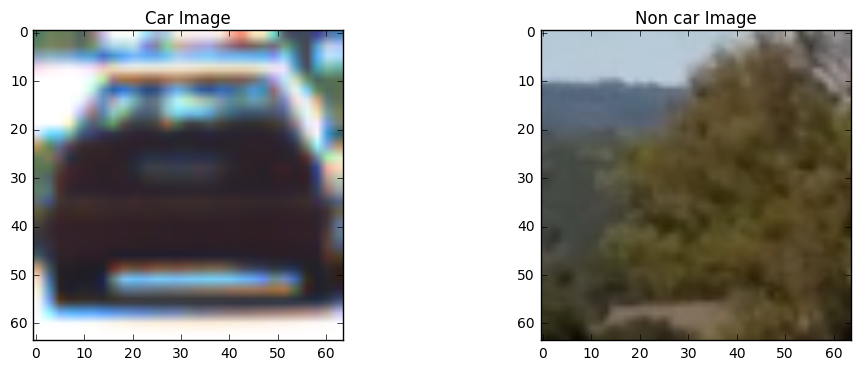

In [21]:
data_info = data_look(cars, notcars)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

fig = plt.figure(figsize=(12,4))
plt.subplot(121)
plt.imshow(car_image)
plt.title('Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Non car Image')

In [22]:
car_features = []
notcar_features = []
i = 0
print('**Starting HOG**')

# Reduce the sample size because HOG features are slow to compute
# The quiz evaluator times out after 13s of CPU time
sample_size = 500
#cars = cars[0:sample_size]
#notcars = notcars[0:sample_size]

### TODO: Tweak these parameters and see how the results change.
color_space = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
spatial_size = (32, 32)
hist_bins = 32
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_feat = True
hist_feat = True
hog_feat = True

t=time.time()
car_features = extract_features(cars, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

notcar_features = extract_features(notcars, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
print("car_features size = ",len(car_features))
print("notcar_features size = ",len(notcar_features))
print('**DONE HOG**')

t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64) 
print("X size = ",X.size)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
print("X_scaler = ",X_scaler.mean_)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

print("Size of scaled_X = ",scaled_X.shape)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
print("Size of y = ",len(y))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

**Starting HOG**
Extract features size =  8792
Extract features size =  8968
car_features size =  8792
notcar_features size =  8968
**DONE HOG**
81.04 Seconds to extract HOG features...
X size =  150249600
X_scaler =  [ 0.33578443  0.33688616  0.33746369 ...,  0.01418594  0.01011848
  0.01289342]
Size of scaled_X =  (17760, 8460)
Size of y =  17760
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
29.21 Seconds to train SVC...
Test Accuracy of SVC =  0.9834
My SVC predicts:  [ 0.  1.  0.  0.  1.  1.  0.  1.  1.  0.]
For these 10 labels:  [ 0.  1.  0.  0.  1.  1.  0.  1.  1.  0.]
0.00116 Seconds to predict 10 labels with SVC


In [23]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [24]:
# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [25]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    
    # Return updated heatmap
    return heatmap

In [26]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [27]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [62]:
def get_heatmap(test_image):
    draw_test_image = np.copy(test_image)
    test_image = test_image.astype(np.float32)/255
    
    
    y_start_stop = [400, 656] # Min and max in y to search in slide_window()
    x_start_stop = [None, None]
    windows = slide_window(test_image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

    hot_windows = search_windows(test_image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

    window_img = draw_boxes(draw_test_image, hot_windows, color=(0, 0, 1), thick=6)                    

    #plt.imshow(window_img)
    
    # Read in the last image shown above 
    test_image1 = mpimg.imread(t_img)
    draw_test_image1 = np.copy(test_image1)
    
    heatmap = np.zeros_like(test_image1[:,:,0])
    test_image1 = test_image1.astype(np.float32)/255
    
    test_image1_tosearch = test_image1[y_start:y_stop,:,:]
    ctrans_tosearch = cv2.cvtColor(test_image1_tosearch, cv2.COLOR_RGB2YCrCb)
    if (scale != 1):
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    
    nxblocks = (ch1.shape[1] // pix_per_cell) - 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - 1
    no_features_per_block = orient*cell_per_block**2
    
    window = 64
    no_blocks_per_window = (window // pix_per_cell) - 1
    cells_per_step = 2
    nxsteps = (nxblocks - no_blocks_per_window ) // cells_per_step
    nysteps = (nyblocks - no_blocks_per_window ) // cells_per_step
    
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
    
    print("nxblocks = ",nxblocks)
    print("nyblocks = ",nyblocks)
    
    print("no_features_per_block = ",no_features_per_block)
    
    print("window = ",window)
    print("no_blocks_per_window = ",no_blocks_per_window)
    print("nxsteps = ",nxsteps)
    print("nysteps = ",nysteps)
    
    img_boxes = []
    count = 0
    for xb in range(nxsteps):
        for yb in range(nysteps):
            count += 1
            ypos = yb * cells_per_step
            xpos = xb * cells_per_step
            hog_feature1 = hog1[ypos:ypos + no_blocks_per_window, xpos:xpos + no_blocks_per_window].ravel()
            hog_feature2 = hog2[ypos:ypos + no_blocks_per_window, xpos:xpos + no_blocks_per_window].ravel()
            hog_feature3 = hog3[ypos:ypos + no_blocks_per_window, xpos:xpos + no_blocks_per_window].ravel()
            hog_features = np.hstack((hog_feature1,hog_feature2,hog_feature3))
    
            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell
    
            #Extract sub image
            sub_image = cv2.resize(ctrans_tosearch[ytop:ytop+window,xleft:xleft+window],(64,64))

            spatial_features = bin_spatial(sub_image, size=spatial_size)
            hist_features = color_hist(sub_image, nbins=hist_bins) 

            test_features = X_scaler.transform(np.hstack((spatial_features,hist_features,hog_features)))
            test_prediction = svc.predict(test_features)

            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_test_image1,(xbox_left,ytop_draw+y_start),(xbox_left+win_draw,ytop_draw+win_draw+y_start),(0,0,255))
                img_boxes.append(((xbox_left,ytop_draw+y_start),(xbox_left+win_draw,ytop_draw+win_draw+y_start)))
                heatmap[ytop_draw+y_start:ytop_draw+win_draw+y_start,xbox_left:xbox_left+win_draw] += 1
            

    return window_img, draw_test_image1,heatmap

In [ ]:
-

## Video Processing

In [54]:
def process_image(image):
    
    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    window_img, out_image, heatmap = get_heatmap(test_image)
    heatmap = apply_threshold(heatmap, 2)
    labels = label(heatmap)
    draw_image = draw_labeled_bboxes(np.copy(out_image), labels)
    
    return draw_image

In [55]:


clip1 = VideoFileClip("project_video.mp4")
lane_clip = clip1.fl_image(process_image)
%time lane_clip.write_videofile("with_cars.mp4", audio=False)

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12
[MoviePy] >>>> Building video with_cars.mp4
[MoviePy] Writing video with_cars.mp4


  0%|          | 0/1261 [00:00<?, ?it/s]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  0%|          | 1/1261 [00:02<45:40,  2.18s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  0%|          | 2/1261 [00:04<45:19,  2.16s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  0%|          | 3/1261 [00:06<45:24,  2.17s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  0%|          | 4/1261 [00:08<45:37,  2.18s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  0%|          | 5/1261 [00:10<46:26,  2.22s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  0%|          | 6/1261 [00:13<47:13,  2.26s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  1%|          | 7/1261 [00:15<47:26,  2.27s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  1%|          | 8/1261 [00:17<47:26,  2.27s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  1%|          | 9/1261 [00:20<47:37,  2.28s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  1%|          | 10/1261 [00:22<47:33,  2.28s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  1%|          | 11/1261 [00:24<48:04,  2.31s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  1%|          | 12/1261 [00:27<48:32,  2.33s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  1%|          | 13/1261 [00:29<48:31,  2.33s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  1%|          | 14/1261 [00:31<48:39,  2.34s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  1%|          | 15/1261 [00:34<49:07,  2.37s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  1%|▏         | 16/1261 [00:36<48:39,  2.35s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  1%|▏         | 17/1261 [00:39<48:38,  2.35s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  1%|▏         | 18/1261 [00:41<48:43,  2.35s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  2%|▏         | 19/1261 [00:43<48:42,  2.35s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  2%|▏         | 20/1261 [00:46<49:20,  2.39s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  2%|▏         | 21/1261 [00:49<51:59,  2.52s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  2%|▏         | 22/1261 [00:52<55:56,  2.71s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  2%|▏         | 23/1261 [00:54<55:56,  2.71s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  2%|▏         | 24/1261 [00:57<56:33,  2.74s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  2%|▏         | 25/1261 [01:00<59:17,  2.88s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  2%|▏         | 26/1261 [01:03<1:00:26,  2.94s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  2%|▏         | 27/1261 [01:07<1:02:57,  3.06s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  2%|▏         | 28/1261 [01:10<1:04:42,  3.15s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  2%|▏         | 29/1261 [01:13<1:04:25,  3.14s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  2%|▏         | 30/1261 [01:16<1:01:53,  3.02s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  2%|▏         | 31/1261 [01:19<59:20,  2.90s/it]  

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  3%|▎         | 32/1261 [01:21<57:45,  2.82s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  3%|▎         | 33/1261 [01:24<56:22,  2.75s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  3%|▎         | 34/1261 [01:27<55:26,  2.71s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  3%|▎         | 35/1261 [01:29<55:53,  2.74s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  3%|▎         | 36/1261 [01:32<55:52,  2.74s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  3%|▎         | 37/1261 [01:35<57:03,  2.80s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  3%|▎         | 38/1261 [01:38<56:35,  2.78s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  3%|▎         | 39/1261 [01:40<56:13,  2.76s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  3%|▎         | 40/1261 [01:43<56:07,  2.76s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  3%|▎         | 41/1261 [01:46<56:21,  2.77s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  3%|▎         | 42/1261 [01:49<56:05,  2.76s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  3%|▎         | 43/1261 [01:51<55:56,  2.76s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  3%|▎         | 44/1261 [01:54<56:04,  2.76s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  4%|▎         | 45/1261 [01:57<55:56,  2.76s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  4%|▎         | 46/1261 [02:00<55:59,  2.76s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  4%|▎         | 47/1261 [02:02<55:37,  2.75s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  4%|▍         | 48/1261 [02:05<55:20,  2.74s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  4%|▍         | 49/1261 [02:08<54:38,  2.71s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  4%|▍         | 50/1261 [02:10<54:04,  2.68s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  4%|▍         | 51/1261 [02:13<53:47,  2.67s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  4%|▍         | 52/1261 [02:16<53:26,  2.65s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  4%|▍         | 53/1261 [02:18<53:03,  2.64s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  4%|▍         | 54/1261 [02:21<52:53,  2.63s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  4%|▍         | 55/1261 [02:24<52:57,  2.63s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  4%|▍         | 56/1261 [02:26<52:53,  2.63s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  5%|▍         | 57/1261 [02:29<52:40,  2.62s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  5%|▍         | 58/1261 [02:31<52:38,  2.63s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  5%|▍         | 59/1261 [02:34<51:56,  2.59s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  5%|▍         | 60/1261 [02:36<51:23,  2.57s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  5%|▍         | 61/1261 [02:39<50:59,  2.55s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  5%|▍         | 62/1261 [02:41<50:47,  2.54s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  5%|▍         | 63/1261 [02:44<50:33,  2.53s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  5%|▌         | 64/1261 [02:47<52:32,  2.63s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  5%|▌         | 65/1261 [02:49<52:23,  2.63s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  5%|▌         | 66/1261 [02:52<51:44,  2.60s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  5%|▌         | 67/1261 [02:55<51:16,  2.58s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  5%|▌         | 68/1261 [02:57<50:50,  2.56s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  5%|▌         | 69/1261 [03:00<50:39,  2.55s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  6%|▌         | 70/1261 [03:02<50:12,  2.53s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  6%|▌         | 71/1261 [03:04<49:37,  2.50s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  6%|▌         | 72/1261 [03:07<48:59,  2.47s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  6%|▌         | 73/1261 [03:09<48:41,  2.46s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  6%|▌         | 74/1261 [03:12<48:53,  2.47s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  6%|▌         | 75/1261 [03:14<49:08,  2.49s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  6%|▌         | 76/1261 [03:17<49:02,  2.48s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  6%|▌         | 77/1261 [03:19<48:40,  2.47s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  6%|▌         | 78/1261 [03:22<48:19,  2.45s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  6%|▋         | 79/1261 [03:24<48:06,  2.44s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  6%|▋         | 80/1261 [03:27<48:01,  2.44s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  6%|▋         | 81/1261 [03:29<48:21,  2.46s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  7%|▋         | 82/1261 [03:32<48:39,  2.48s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  7%|▋         | 83/1261 [03:34<48:33,  2.47s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  7%|▋         | 84/1261 [03:36<48:33,  2.47s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  7%|▋         | 85/1261 [03:39<48:08,  2.46s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  7%|▋         | 86/1261 [03:41<47:58,  2.45s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  7%|▋         | 87/1261 [03:44<47:50,  2.45s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  7%|▋         | 88/1261 [03:46<47:44,  2.44s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  7%|▋         | 89/1261 [03:49<47:42,  2.44s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  7%|▋         | 90/1261 [03:51<47:34,  2.44s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  7%|▋         | 91/1261 [03:54<47:37,  2.44s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  7%|▋         | 92/1261 [03:56<48:03,  2.47s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  7%|▋         | 93/1261 [03:59<48:05,  2.47s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  7%|▋         | 94/1261 [04:01<47:52,  2.46s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  8%|▊         | 95/1261 [04:03<47:34,  2.45s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  8%|▊         | 96/1261 [04:06<47:29,  2.45s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  8%|▊         | 97/1261 [04:08<47:16,  2.44s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  8%|▊         | 98/1261 [04:11<47:13,  2.44s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  8%|▊         | 99/1261 [04:13<47:14,  2.44s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  8%|▊         | 100/1261 [04:16<47:10,  2.44s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  8%|▊         | 101/1261 [04:18<47:00,  2.43s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  8%|▊         | 102/1261 [04:20<47:16,  2.45s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  8%|▊         | 103/1261 [04:23<47:37,  2.47s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  8%|▊         | 104/1261 [04:26<49:20,  2.56s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  8%|▊         | 105/1261 [04:29<54:15,  2.82s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  8%|▊         | 106/1261 [04:32<56:40,  2.94s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  8%|▊         | 107/1261 [04:35<56:24,  2.93s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  9%|▊         | 108/1261 [04:38<54:36,  2.84s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  9%|▊         | 109/1261 [04:40<52:48,  2.75s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  9%|▊         | 110/1261 [04:43<51:24,  2.68s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  9%|▉         | 111/1261 [04:45<50:08,  2.62s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  9%|▉         | 112/1261 [04:48<49:04,  2.56s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  9%|▉         | 113/1261 [04:50<48:42,  2.55s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  9%|▉         | 114/1261 [04:53<48:22,  2.53s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  9%|▉         | 115/1261 [04:55<48:13,  2.52s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  9%|▉         | 116/1261 [04:58<48:05,  2.52s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  9%|▉         | 117/1261 [05:00<47:59,  2.52s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  9%|▉         | 118/1261 [05:03<47:49,  2.51s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


  9%|▉         | 119/1261 [05:05<47:53,  2.52s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 10%|▉         | 120/1261 [05:08<47:46,  2.51s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 10%|▉         | 121/1261 [05:10<47:49,  2.52s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 10%|▉         | 122/1261 [05:13<47:42,  2.51s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 10%|▉         | 123/1261 [05:15<47:27,  2.50s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 10%|▉         | 124/1261 [05:18<46:52,  2.47s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 10%|▉         | 125/1261 [05:20<46:37,  2.46s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 10%|▉         | 126/1261 [05:23<46:47,  2.47s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 10%|█         | 127/1261 [05:25<47:00,  2.49s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 10%|█         | 128/1261 [05:28<47:04,  2.49s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 10%|█         | 129/1261 [05:30<47:14,  2.50s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 10%|█         | 130/1261 [05:33<47:02,  2.50s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 10%|█         | 131/1261 [05:35<46:52,  2.49s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 10%|█         | 132/1261 [05:38<46:30,  2.47s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 11%|█         | 133/1261 [05:40<46:32,  2.48s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 11%|█         | 134/1261 [05:43<46:44,  2.49s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 11%|█         | 135/1261 [05:45<47:01,  2.51s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 11%|█         | 136/1261 [05:48<47:01,  2.51s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 11%|█         | 137/1261 [05:50<47:07,  2.52s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 11%|█         | 138/1261 [05:53<46:48,  2.50s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 11%|█         | 139/1261 [05:55<46:38,  2.49s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 11%|█         | 140/1261 [05:58<46:33,  2.49s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 11%|█         | 141/1261 [06:00<46:39,  2.50s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 11%|█▏        | 142/1261 [06:03<46:38,  2.50s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 11%|█▏        | 143/1261 [06:05<47:09,  2.53s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 11%|█▏        | 144/1261 [06:09<50:34,  2.72s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 11%|█▏        | 145/1261 [06:11<51:05,  2.75s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 12%|█▏        | 146/1261 [06:14<50:32,  2.72s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 12%|█▏        | 147/1261 [06:17<49:35,  2.67s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 12%|█▏        | 148/1261 [06:19<48:36,  2.62s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 12%|█▏        | 149/1261 [06:22<47:59,  2.59s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 12%|█▏        | 150/1261 [06:24<47:18,  2.55s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 12%|█▏        | 151/1261 [06:27<47:02,  2.54s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 12%|█▏        | 152/1261 [06:29<46:44,  2.53s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 12%|█▏        | 153/1261 [06:32<46:42,  2.53s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 12%|█▏        | 154/1261 [06:34<46:32,  2.52s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 12%|█▏        | 155/1261 [06:37<46:26,  2.52s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 12%|█▏        | 156/1261 [06:39<46:10,  2.51s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 12%|█▏        | 157/1261 [06:42<45:39,  2.48s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 13%|█▎        | 158/1261 [06:44<45:16,  2.46s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 13%|█▎        | 159/1261 [06:46<45:33,  2.48s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 13%|█▎        | 160/1261 [06:49<45:37,  2.49s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 13%|█▎        | 161/1261 [06:51<45:20,  2.47s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 13%|█▎        | 162/1261 [06:54<45:00,  2.46s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 13%|█▎        | 163/1261 [06:56<44:58,  2.46s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 13%|█▎        | 164/1261 [06:59<44:45,  2.45s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 13%|█▎        | 165/1261 [07:01<44:37,  2.44s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 13%|█▎        | 166/1261 [07:04<44:28,  2.44s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 13%|█▎        | 167/1261 [07:06<44:13,  2.43s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 13%|█▎        | 168/1261 [07:08<43:41,  2.40s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 13%|█▎        | 169/1261 [07:11<43:29,  2.39s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 13%|█▎        | 170/1261 [07:13<43:37,  2.40s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 14%|█▎        | 171/1261 [07:16<43:48,  2.41s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 14%|█▎        | 172/1261 [07:18<43:58,  2.42s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 14%|█▎        | 173/1261 [07:20<43:31,  2.40s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 14%|█▍        | 174/1261 [07:23<43:08,  2.38s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 14%|█▍        | 175/1261 [07:25<42:54,  2.37s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 14%|█▍        | 176/1261 [07:27<42:50,  2.37s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 14%|█▍        | 177/1261 [07:30<43:14,  2.39s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 14%|█▍        | 178/1261 [07:32<43:16,  2.40s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 14%|█▍        | 179/1261 [07:35<43:38,  2.42s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 14%|█▍        | 180/1261 [07:37<43:12,  2.40s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 14%|█▍        | 181/1261 [07:39<42:51,  2.38s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 14%|█▍        | 182/1261 [07:42<42:34,  2.37s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 15%|█▍        | 183/1261 [07:44<42:22,  2.36s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 15%|█▍        | 184/1261 [07:46<42:26,  2.36s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 15%|█▍        | 185/1261 [07:49<42:19,  2.36s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 15%|█▍        | 186/1261 [07:51<42:10,  2.35s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 15%|█▍        | 187/1261 [07:53<42:06,  2.35s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 15%|█▍        | 188/1261 [07:56<42:06,  2.35s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 15%|█▍        | 189/1261 [07:58<41:51,  2.34s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 15%|█▌        | 190/1261 [08:00<41:34,  2.33s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 15%|█▌        | 191/1261 [08:03<41:35,  2.33s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 15%|█▌        | 192/1261 [08:05<41:39,  2.34s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 15%|█▌        | 193/1261 [08:07<41:35,  2.34s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 15%|█▌        | 194/1261 [08:10<41:24,  2.33s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 15%|█▌        | 195/1261 [08:12<40:58,  2.31s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 16%|█▌        | 196/1261 [08:14<40:48,  2.30s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 16%|█▌        | 197/1261 [08:17<40:58,  2.31s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 16%|█▌        | 198/1261 [08:19<41:06,  2.32s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 16%|█▌        | 199/1261 [08:21<41:02,  2.32s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 16%|█▌        | 200/1261 [08:24<40:40,  2.30s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 16%|█▌        | 201/1261 [08:26<40:33,  2.30s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 16%|█▌        | 202/1261 [08:28<40:50,  2.31s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 16%|█▌        | 203/1261 [08:31<40:57,  2.32s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 16%|█▌        | 204/1261 [08:33<40:47,  2.32s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 16%|█▋        | 205/1261 [08:35<40:36,  2.31s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 16%|█▋        | 206/1261 [08:38<40:48,  2.32s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 16%|█▋        | 207/1261 [08:40<40:54,  2.33s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 16%|█▋        | 208/1261 [08:42<40:56,  2.33s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 17%|█▋        | 209/1261 [08:44<40:41,  2.32s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 17%|█▋        | 210/1261 [08:47<40:25,  2.31s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 17%|█▋        | 211/1261 [08:49<40:09,  2.29s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 17%|█▋        | 212/1261 [08:51<40:01,  2.29s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 17%|█▋        | 213/1261 [08:54<39:53,  2.28s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 17%|█▋        | 214/1261 [08:56<40:09,  2.30s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 17%|█▋        | 215/1261 [08:58<40:10,  2.30s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 17%|█▋        | 216/1261 [09:01<39:58,  2.30s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 17%|█▋        | 217/1261 [09:03<39:50,  2.29s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 17%|█▋        | 218/1261 [09:05<39:40,  2.28s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 17%|█▋        | 219/1261 [09:07<39:38,  2.28s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 17%|█▋        | 220/1261 [09:10<39:58,  2.30s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 18%|█▊        | 221/1261 [09:12<40:03,  2.31s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 18%|█▊        | 222/1261 [09:14<39:52,  2.30s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 18%|█▊        | 223/1261 [09:17<39:43,  2.30s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 18%|█▊        | 224/1261 [09:19<39:32,  2.29s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 18%|█▊        | 225/1261 [09:21<39:52,  2.31s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 18%|█▊        | 226/1261 [09:24<40:03,  2.32s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 18%|█▊        | 227/1261 [09:26<39:54,  2.32s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 18%|█▊        | 228/1261 [09:28<39:37,  2.30s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 18%|█▊        | 229/1261 [09:30<39:28,  2.30s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 18%|█▊        | 230/1261 [09:33<39:20,  2.29s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 18%|█▊        | 231/1261 [09:35<39:40,  2.31s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 18%|█▊        | 232/1261 [09:37<39:49,  2.32s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 18%|█▊        | 233/1261 [09:40<39:32,  2.31s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 19%|█▊        | 234/1261 [09:42<39:16,  2.29s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 19%|█▊        | 235/1261 [09:44<39:04,  2.28s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 19%|█▊        | 236/1261 [09:47<39:07,  2.29s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 19%|█▉        | 237/1261 [09:49<39:21,  2.31s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 19%|█▉        | 238/1261 [09:51<39:31,  2.32s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 19%|█▉        | 239/1261 [09:54<39:27,  2.32s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 19%|█▉        | 240/1261 [09:56<39:15,  2.31s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 19%|█▉        | 241/1261 [09:58<39:01,  2.30s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 19%|█▉        | 242/1261 [10:00<39:16,  2.31s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 19%|█▉        | 243/1261 [10:03<39:24,  2.32s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 19%|█▉        | 244/1261 [10:05<39:33,  2.33s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 19%|█▉        | 245/1261 [10:07<39:18,  2.32s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 20%|█▉        | 246/1261 [10:10<38:59,  2.31s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 20%|█▉        | 247/1261 [10:12<38:49,  2.30s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 20%|█▉        | 248/1261 [10:14<39:03,  2.31s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 20%|█▉        | 249/1261 [10:17<39:11,  2.32s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 20%|█▉        | 250/1261 [10:19<39:18,  2.33s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 20%|█▉        | 251/1261 [10:21<39:08,  2.33s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 20%|█▉        | 252/1261 [10:24<38:50,  2.31s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 20%|██        | 253/1261 [10:26<38:42,  2.30s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 20%|██        | 254/1261 [10:28<38:51,  2.31s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 20%|██        | 255/1261 [10:31<39:03,  2.33s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 20%|██        | 256/1261 [10:33<39:01,  2.33s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 20%|██        | 257/1261 [10:35<39:06,  2.34s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 20%|██        | 258/1261 [10:38<38:59,  2.33s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 21%|██        | 259/1261 [10:40<38:38,  2.31s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 21%|██        | 260/1261 [10:42<38:44,  2.32s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 21%|██        | 261/1261 [10:45<38:49,  2.33s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 21%|██        | 262/1261 [10:47<38:51,  2.33s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 21%|██        | 263/1261 [10:49<38:54,  2.34s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 21%|██        | 264/1261 [10:52<38:50,  2.34s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 21%|██        | 265/1261 [10:54<38:33,  2.32s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 21%|██        | 266/1261 [10:56<38:26,  2.32s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 21%|██        | 267/1261 [10:59<38:31,  2.33s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 21%|██▏       | 268/1261 [11:01<38:42,  2.34s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 21%|██▏       | 269/1261 [11:03<38:41,  2.34s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 21%|██▏       | 270/1261 [11:06<38:44,  2.35s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 21%|██▏       | 271/1261 [11:08<38:44,  2.35s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 22%|██▏       | 272/1261 [11:10<39:05,  2.37s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 22%|██▏       | 273/1261 [11:13<40:58,  2.49s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 22%|██▏       | 274/1261 [11:16<44:48,  2.72s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 22%|██▏       | 275/1261 [11:19<46:02,  2.80s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 22%|██▏       | 276/1261 [11:22<46:59,  2.86s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 22%|██▏       | 277/1261 [11:25<46:04,  2.81s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 22%|██▏       | 278/1261 [11:28<44:44,  2.73s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 22%|██▏       | 279/1261 [11:30<42:51,  2.62s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 22%|██▏       | 280/1261 [11:32<41:07,  2.52s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 22%|██▏       | 281/1261 [11:35<39:57,  2.45s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 22%|██▏       | 282/1261 [11:37<39:05,  2.40s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 22%|██▏       | 283/1261 [11:39<38:28,  2.36s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 23%|██▎       | 284/1261 [11:41<38:06,  2.34s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 23%|██▎       | 285/1261 [11:44<38:13,  2.35s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 23%|██▎       | 286/1261 [11:46<37:57,  2.34s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 23%|██▎       | 287/1261 [11:48<37:41,  2.32s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 23%|██▎       | 288/1261 [11:51<37:27,  2.31s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 23%|██▎       | 289/1261 [11:53<36:57,  2.28s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 23%|██▎       | 290/1261 [11:55<36:30,  2.26s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 23%|██▎       | 291/1261 [11:57<36:13,  2.24s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 23%|██▎       | 292/1261 [11:59<36:03,  2.23s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 23%|██▎       | 293/1261 [12:02<35:52,  2.22s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 23%|██▎       | 294/1261 [12:04<35:42,  2.22s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 23%|██▎       | 295/1261 [12:06<35:36,  2.21s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 23%|██▎       | 296/1261 [12:08<35:31,  2.21s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 24%|██▎       | 297/1261 [12:10<35:32,  2.21s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 24%|██▎       | 298/1261 [12:13<35:31,  2.21s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 24%|██▎       | 299/1261 [12:15<35:25,  2.21s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 24%|██▍       | 300/1261 [12:17<35:42,  2.23s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 24%|██▍       | 301/1261 [12:19<35:23,  2.21s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 24%|██▍       | 302/1261 [12:22<35:05,  2.20s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 24%|██▍       | 303/1261 [12:24<35:14,  2.21s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 24%|██▍       | 304/1261 [12:26<35:07,  2.20s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 24%|██▍       | 305/1261 [12:28<35:06,  2.20s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 24%|██▍       | 306/1261 [12:30<35:07,  2.21s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 24%|██▍       | 307/1261 [12:33<35:08,  2.21s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 24%|██▍       | 308/1261 [12:35<35:32,  2.24s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 25%|██▍       | 309/1261 [12:37<35:42,  2.25s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 25%|██▍       | 310/1261 [12:39<35:36,  2.25s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 25%|██▍       | 311/1261 [12:42<35:21,  2.23s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 25%|██▍       | 312/1261 [12:44<35:14,  2.23s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 25%|██▍       | 313/1261 [12:46<35:10,  2.23s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 25%|██▍       | 314/1261 [12:48<36:02,  2.28s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 25%|██▍       | 315/1261 [12:51<36:20,  2.30s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 25%|██▌       | 316/1261 [12:53<36:00,  2.29s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 25%|██▌       | 317/1261 [12:55<35:37,  2.26s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 25%|██▌       | 318/1261 [12:58<35:34,  2.26s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 25%|██▌       | 319/1261 [13:00<35:43,  2.28s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 25%|██▌       | 320/1261 [13:02<35:52,  2.29s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 25%|██▌       | 321/1261 [13:05<36:14,  2.31s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 26%|██▌       | 322/1261 [13:07<36:24,  2.33s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 26%|██▌       | 323/1261 [13:09<35:50,  2.29s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 26%|██▌       | 324/1261 [13:11<35:23,  2.27s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 26%|██▌       | 325/1261 [13:14<35:14,  2.26s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 26%|██▌       | 326/1261 [13:16<35:26,  2.27s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 26%|██▌       | 327/1261 [13:18<35:13,  2.26s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 26%|██▌       | 328/1261 [13:20<35:01,  2.25s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 26%|██▌       | 329/1261 [13:23<34:58,  2.25s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 26%|██▌       | 330/1261 [13:25<35:09,  2.27s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 26%|██▌       | 331/1261 [13:27<35:03,  2.26s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 26%|██▋       | 332/1261 [13:29<34:47,  2.25s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 26%|██▋       | 333/1261 [13:32<34:49,  2.25s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 26%|██▋       | 334/1261 [13:34<34:52,  2.26s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 27%|██▋       | 335/1261 [13:36<34:49,  2.26s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 27%|██▋       | 336/1261 [13:38<34:35,  2.24s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 27%|██▋       | 337/1261 [13:41<34:46,  2.26s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 27%|██▋       | 338/1261 [13:43<34:44,  2.26s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 27%|██▋       | 339/1261 [13:45<34:43,  2.26s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 27%|██▋       | 340/1261 [13:47<34:25,  2.24s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 27%|██▋       | 341/1261 [13:50<35:54,  2.34s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 27%|██▋       | 342/1261 [13:53<38:13,  2.50s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 27%|██▋       | 343/1261 [13:56<40:10,  2.63s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 27%|██▋       | 344/1261 [13:59<41:33,  2.72s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 27%|██▋       | 345/1261 [14:01<39:51,  2.61s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 27%|██▋       | 346/1261 [14:03<38:02,  2.49s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 28%|██▊       | 347/1261 [14:05<36:39,  2.41s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 28%|██▊       | 348/1261 [14:08<35:41,  2.35s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 28%|██▊       | 349/1261 [14:10<35:04,  2.31s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 28%|██▊       | 350/1261 [14:12<34:50,  2.29s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 28%|██▊       | 351/1261 [14:14<34:54,  2.30s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 28%|██▊       | 352/1261 [14:17<34:50,  2.30s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 28%|██▊       | 353/1261 [14:19<34:35,  2.29s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 28%|██▊       | 354/1261 [14:21<34:13,  2.26s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 28%|██▊       | 355/1261 [14:24<34:37,  2.29s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 28%|██▊       | 356/1261 [14:26<35:35,  2.36s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 28%|██▊       | 357/1261 [14:28<35:30,  2.36s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 28%|██▊       | 358/1261 [14:31<35:07,  2.33s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 28%|██▊       | 359/1261 [14:33<34:49,  2.32s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 29%|██▊       | 360/1261 [14:35<34:19,  2.29s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 29%|██▊       | 361/1261 [14:37<33:58,  2.26s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 29%|██▊       | 362/1261 [14:40<34:01,  2.27s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 29%|██▉       | 363/1261 [14:42<33:59,  2.27s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 29%|██▉       | 364/1261 [14:44<33:53,  2.27s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 29%|██▉       | 365/1261 [14:46<33:37,  2.25s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 29%|██▉       | 366/1261 [14:49<33:47,  2.27s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 29%|██▉       | 367/1261 [14:51<33:46,  2.27s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 29%|██▉       | 368/1261 [14:53<33:47,  2.27s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 29%|██▉       | 369/1261 [14:56<33:48,  2.27s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 29%|██▉       | 370/1261 [14:58<33:48,  2.28s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 29%|██▉       | 371/1261 [15:00<33:36,  2.27s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 30%|██▉       | 372/1261 [15:02<33:20,  2.25s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 30%|██▉       | 373/1261 [15:05<33:23,  2.26s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 30%|██▉       | 374/1261 [15:07<33:25,  2.26s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 30%|██▉       | 375/1261 [15:09<33:28,  2.27s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 30%|██▉       | 376/1261 [15:11<33:29,  2.27s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 30%|██▉       | 377/1261 [15:14<33:25,  2.27s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 30%|██▉       | 378/1261 [15:16<33:17,  2.26s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 30%|███       | 379/1261 [15:18<33:06,  2.25s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 30%|███       | 380/1261 [15:20<33:07,  2.26s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 30%|███       | 381/1261 [15:23<33:07,  2.26s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 30%|███       | 382/1261 [15:25<33:07,  2.26s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 30%|███       | 383/1261 [15:27<33:08,  2.27s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 30%|███       | 384/1261 [15:29<33:09,  2.27s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 31%|███       | 385/1261 [15:32<33:04,  2.27s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 31%|███       | 386/1261 [15:34<33:02,  2.27s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 31%|███       | 387/1261 [15:36<33:02,  2.27s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 31%|███       | 388/1261 [15:39<33:00,  2.27s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 31%|███       | 389/1261 [15:41<33:01,  2.27s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 31%|███       | 390/1261 [15:43<32:58,  2.27s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 31%|███       | 391/1261 [15:45<32:56,  2.27s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 31%|███       | 392/1261 [15:48<32:57,  2.28s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 31%|███       | 393/1261 [15:50<32:55,  2.28s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 31%|███       | 394/1261 [15:52<33:18,  2.30s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 31%|███▏      | 395/1261 [15:55<33:20,  2.31s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 31%|███▏      | 396/1261 [15:57<33:06,  2.30s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 31%|███▏      | 397/1261 [15:59<33:02,  2.29s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 32%|███▏      | 398/1261 [16:01<32:53,  2.29s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 32%|███▏      | 399/1261 [16:04<33:04,  2.30s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 32%|███▏      | 400/1261 [16:06<33:16,  2.32s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 32%|███▏      | 401/1261 [16:08<33:05,  2.31s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 32%|███▏      | 402/1261 [16:11<32:55,  2.30s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 32%|███▏      | 403/1261 [16:13<32:46,  2.29s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 32%|███▏      | 404/1261 [16:15<32:50,  2.30s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 32%|███▏      | 405/1261 [16:18<33:00,  2.31s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 32%|███▏      | 406/1261 [16:20<33:08,  2.33s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 32%|███▏      | 407/1261 [16:22<33:03,  2.32s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 32%|███▏      | 408/1261 [16:25<32:55,  2.32s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 32%|███▏      | 409/1261 [16:27<32:42,  2.30s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 33%|███▎      | 410/1261 [16:29<32:55,  2.32s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 33%|███▎      | 411/1261 [16:32<33:01,  2.33s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 33%|███▎      | 412/1261 [16:34<33:05,  2.34s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 33%|███▎      | 413/1261 [16:36<32:56,  2.33s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 33%|███▎      | 414/1261 [16:39<32:37,  2.31s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 33%|███▎      | 415/1261 [16:41<32:38,  2.31s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 33%|███▎      | 416/1261 [16:43<32:44,  2.32s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 33%|███▎      | 417/1261 [16:46<32:49,  2.33s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 33%|███▎      | 418/1261 [16:48<32:50,  2.34s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 33%|███▎      | 419/1261 [16:50<32:41,  2.33s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 33%|███▎      | 420/1261 [16:52<32:21,  2.31s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 33%|███▎      | 421/1261 [16:55<32:30,  2.32s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 33%|███▎      | 422/1261 [16:57<32:33,  2.33s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 34%|███▎      | 423/1261 [17:00<32:39,  2.34s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 34%|███▎      | 424/1261 [17:02<32:35,  2.34s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 34%|███▎      | 425/1261 [17:04<32:37,  2.34s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 34%|███▍      | 426/1261 [17:07<32:24,  2.33s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 34%|███▍      | 427/1261 [17:09<32:08,  2.31s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 34%|███▍      | 428/1261 [17:11<32:04,  2.31s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 34%|███▍      | 429/1261 [17:13<32:09,  2.32s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 34%|███▍      | 430/1261 [17:16<32:19,  2.33s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 34%|███▍      | 431/1261 [17:18<32:19,  2.34s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 34%|███▍      | 432/1261 [17:21<32:23,  2.34s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 34%|███▍      | 433/1261 [17:23<32:17,  2.34s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 34%|███▍      | 434/1261 [17:25<32:11,  2.34s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 34%|███▍      | 435/1261 [17:27<32:00,  2.32s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 35%|███▍      | 436/1261 [17:30<32:04,  2.33s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 35%|███▍      | 437/1261 [17:32<32:04,  2.34s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 35%|███▍      | 438/1261 [17:35<32:03,  2.34s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 35%|███▍      | 439/1261 [17:37<32:04,  2.34s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 35%|███▍      | 440/1261 [17:39<32:16,  2.36s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 35%|███▍      | 441/1261 [17:42<32:09,  2.35s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 35%|███▌      | 442/1261 [17:44<32:03,  2.35s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 35%|███▌      | 443/1261 [17:46<31:56,  2.34s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 35%|███▌      | 444/1261 [17:49<32:01,  2.35s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 35%|███▌      | 445/1261 [17:51<32:01,  2.35s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 35%|███▌      | 446/1261 [17:53<31:55,  2.35s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 35%|███▌      | 447/1261 [17:56<31:52,  2.35s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 36%|███▌      | 448/1261 [17:58<31:56,  2.36s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 36%|███▌      | 449/1261 [18:00<31:53,  2.36s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 36%|███▌      | 450/1261 [18:03<31:51,  2.36s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 36%|███▌      | 451/1261 [18:05<31:47,  2.35s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 36%|███▌      | 452/1261 [18:07<31:39,  2.35s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 36%|███▌      | 453/1261 [18:10<31:39,  2.35s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 36%|███▌      | 454/1261 [18:12<31:34,  2.35s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 36%|███▌      | 455/1261 [18:15<31:31,  2.35s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 36%|███▌      | 456/1261 [18:17<31:27,  2.35s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 36%|███▌      | 457/1261 [18:19<31:28,  2.35s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 36%|███▋      | 458/1261 [18:22<31:18,  2.34s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 36%|███▋      | 459/1261 [18:24<30:58,  2.32s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 36%|███▋      | 460/1261 [18:26<30:57,  2.32s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 37%|███▋      | 461/1261 [18:28<31:04,  2.33s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 37%|███▋      | 462/1261 [18:31<31:13,  2.34s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 37%|███▋      | 463/1261 [18:33<31:10,  2.34s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 37%|███▋      | 464/1261 [18:36<31:20,  2.36s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 37%|███▋      | 465/1261 [18:38<31:14,  2.35s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 37%|███▋      | 466/1261 [18:40<31:14,  2.36s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 37%|███▋      | 467/1261 [18:43<31:08,  2.35s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 37%|███▋      | 468/1261 [18:45<31:02,  2.35s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 37%|███▋      | 469/1261 [18:47<30:56,  2.34s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 37%|███▋      | 470/1261 [18:50<30:59,  2.35s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 37%|███▋      | 471/1261 [18:52<30:58,  2.35s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 37%|███▋      | 472/1261 [18:54<30:53,  2.35s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 38%|███▊      | 473/1261 [18:57<30:53,  2.35s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 38%|███▊      | 474/1261 [18:59<30:54,  2.36s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 38%|███▊      | 475/1261 [19:01<30:55,  2.36s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 38%|███▊      | 476/1261 [19:04<30:46,  2.35s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 38%|███▊      | 477/1261 [19:06<30:42,  2.35s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 38%|███▊      | 478/1261 [19:08<30:40,  2.35s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 38%|███▊      | 479/1261 [19:11<30:39,  2.35s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 38%|███▊      | 480/1261 [19:13<30:34,  2.35s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 38%|███▊      | 481/1261 [19:16<30:49,  2.37s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 38%|███▊      | 482/1261 [19:18<30:42,  2.37s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 38%|███▊      | 483/1261 [19:20<30:59,  2.39s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 38%|███▊      | 484/1261 [19:23<30:58,  2.39s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 38%|███▊      | 485/1261 [19:25<30:46,  2.38s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 39%|███▊      | 486/1261 [19:28<30:38,  2.37s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 39%|███▊      | 487/1261 [19:30<30:46,  2.39s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 39%|███▊      | 488/1261 [19:32<30:40,  2.38s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 39%|███▉      | 489/1261 [19:35<30:32,  2.37s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 39%|███▉      | 490/1261 [19:37<30:21,  2.36s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 39%|███▉      | 491/1261 [19:39<30:17,  2.36s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 39%|███▉      | 492/1261 [19:42<30:28,  2.38s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 39%|███▉      | 493/1261 [19:44<30:26,  2.38s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 39%|███▉      | 494/1261 [19:46<30:14,  2.37s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 39%|███▉      | 495/1261 [19:49<30:08,  2.36s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 39%|███▉      | 496/1261 [19:51<30:02,  2.36s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 39%|███▉      | 497/1261 [19:54<29:57,  2.35s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 39%|███▉      | 498/1261 [19:56<29:54,  2.35s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 40%|███▉      | 499/1261 [19:58<29:53,  2.35s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 40%|███▉      | 500/1261 [20:01<30:10,  2.38s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 40%|███▉      | 501/1261 [20:03<30:18,  2.39s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 40%|███▉      | 502/1261 [20:05<30:14,  2.39s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 40%|███▉      | 503/1261 [20:08<30:01,  2.38s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 40%|███▉      | 504/1261 [20:10<29:53,  2.37s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 40%|████      | 505/1261 [20:13<29:43,  2.36s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 40%|████      | 506/1261 [20:15<29:44,  2.36s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 40%|████      | 507/1261 [20:17<29:54,  2.38s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 40%|████      | 508/1261 [20:20<30:03,  2.40s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 40%|████      | 509/1261 [20:22<29:48,  2.38s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 40%|████      | 510/1261 [20:24<29:42,  2.37s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 41%|████      | 511/1261 [20:27<29:34,  2.37s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 41%|████      | 512/1261 [20:29<29:31,  2.36s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 41%|████      | 513/1261 [20:31<29:22,  2.36s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 41%|████      | 514/1261 [20:34<29:13,  2.35s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 41%|████      | 515/1261 [20:36<29:15,  2.35s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 41%|████      | 516/1261 [20:39<29:08,  2.35s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 41%|████      | 517/1261 [20:41<29:28,  2.38s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 41%|████      | 518/1261 [20:43<29:27,  2.38s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 41%|████      | 519/1261 [20:46<29:18,  2.37s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 41%|████      | 520/1261 [20:48<29:10,  2.36s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 41%|████▏     | 521/1261 [20:50<29:08,  2.36s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 41%|████▏     | 522/1261 [20:53<29:00,  2.36s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 41%|████▏     | 523/1261 [20:55<28:56,  2.35s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 42%|████▏     | 524/1261 [20:57<28:44,  2.34s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 42%|████▏     | 525/1261 [21:00<28:31,  2.33s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 42%|████▏     | 526/1261 [21:02<28:19,  2.31s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 42%|████▏     | 527/1261 [21:04<28:24,  2.32s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 42%|████▏     | 528/1261 [21:07<28:30,  2.33s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 42%|████▏     | 529/1261 [21:09<28:30,  2.34s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 42%|████▏     | 530/1261 [21:11<28:33,  2.34s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 42%|████▏     | 531/1261 [21:14<28:15,  2.32s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 42%|████▏     | 532/1261 [21:16<28:00,  2.30s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 42%|████▏     | 533/1261 [21:18<27:56,  2.30s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 42%|████▏     | 534/1261 [21:21<28:05,  2.32s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 42%|████▏     | 535/1261 [21:23<28:09,  2.33s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 43%|████▎     | 536/1261 [21:25<28:12,  2.34s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 43%|████▎     | 537/1261 [21:28<28:03,  2.33s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 43%|████▎     | 538/1261 [21:30<27:54,  2.32s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 43%|████▎     | 539/1261 [21:32<27:42,  2.30s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 43%|████▎     | 540/1261 [21:34<27:50,  2.32s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 43%|████▎     | 541/1261 [21:37<27:55,  2.33s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 43%|████▎     | 542/1261 [21:39<27:59,  2.34s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 43%|████▎     | 543/1261 [21:41<27:43,  2.32s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 43%|████▎     | 544/1261 [21:44<27:36,  2.31s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 43%|████▎     | 545/1261 [21:46<27:44,  2.32s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 43%|████▎     | 546/1261 [21:48<27:46,  2.33s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 43%|████▎     | 547/1261 [21:51<27:49,  2.34s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 43%|████▎     | 548/1261 [21:53<27:31,  2.32s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 44%|████▎     | 549/1261 [21:55<27:22,  2.31s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 44%|████▎     | 550/1261 [21:58<27:17,  2.30s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 44%|████▎     | 551/1261 [22:00<27:27,  2.32s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 44%|████▍     | 552/1261 [22:02<27:28,  2.33s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 44%|████▍     | 553/1261 [22:05<27:25,  2.32s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 44%|████▍     | 554/1261 [22:07<27:10,  2.31s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 44%|████▍     | 555/1261 [22:09<27:10,  2.31s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 44%|████▍     | 556/1261 [22:12<27:15,  2.32s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 44%|████▍     | 557/1261 [22:14<27:18,  2.33s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 44%|████▍     | 558/1261 [22:16<27:20,  2.33s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 44%|████▍     | 559/1261 [22:19<27:13,  2.33s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 44%|████▍     | 560/1261 [22:21<27:07,  2.32s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 44%|████▍     | 561/1261 [22:23<26:57,  2.31s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 45%|████▍     | 562/1261 [22:26<27:04,  2.32s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 45%|████▍     | 563/1261 [22:28<27:06,  2.33s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 45%|████▍     | 564/1261 [22:30<27:12,  2.34s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 45%|████▍     | 565/1261 [22:33<27:09,  2.34s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 45%|████▍     | 566/1261 [22:35<26:58,  2.33s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 45%|████▍     | 567/1261 [22:37<26:41,  2.31s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 45%|████▌     | 568/1261 [22:40<26:49,  2.32s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 45%|████▌     | 569/1261 [22:42<26:54,  2.33s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 45%|████▌     | 570/1261 [22:44<26:54,  2.34s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 45%|████▌     | 571/1261 [22:47<26:47,  2.33s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 45%|████▌     | 572/1261 [22:49<26:34,  2.31s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 45%|████▌     | 573/1261 [22:51<26:55,  2.35s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 46%|████▌     | 574/1261 [22:54<26:48,  2.34s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 46%|████▌     | 575/1261 [22:56<26:47,  2.34s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 46%|████▌     | 576/1261 [22:58<26:44,  2.34s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 46%|████▌     | 577/1261 [23:01<26:45,  2.35s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 46%|████▌     | 578/1261 [23:03<26:40,  2.34s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 46%|████▌     | 579/1261 [23:05<26:27,  2.33s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 46%|████▌     | 580/1261 [23:08<26:17,  2.32s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 46%|████▌     | 581/1261 [23:10<26:25,  2.33s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 46%|████▌     | 582/1261 [23:12<26:29,  2.34s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 46%|████▌     | 583/1261 [23:15<26:27,  2.34s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 46%|████▋     | 584/1261 [23:17<26:23,  2.34s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 46%|████▋     | 585/1261 [23:19<26:22,  2.34s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 46%|████▋     | 586/1261 [23:22<26:19,  2.34s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 47%|████▋     | 587/1261 [23:24<26:04,  2.32s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 47%|████▋     | 588/1261 [23:26<26:08,  2.33s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 47%|████▋     | 589/1261 [23:29<26:09,  2.34s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 47%|████▋     | 590/1261 [23:31<26:14,  2.35s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 47%|████▋     | 591/1261 [23:33<26:10,  2.34s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 47%|████▋     | 592/1261 [23:36<26:17,  2.36s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 47%|████▋     | 593/1261 [23:38<26:12,  2.35s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 47%|████▋     | 594/1261 [23:40<26:14,  2.36s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 47%|████▋     | 595/1261 [23:43<26:07,  2.35s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 47%|████▋     | 596/1261 [23:45<26:09,  2.36s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 47%|████▋     | 597/1261 [23:47<26:04,  2.36s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 47%|████▋     | 598/1261 [23:50<26:04,  2.36s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 48%|████▊     | 599/1261 [23:52<26:02,  2.36s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 48%|████▊     | 600/1261 [23:55<25:58,  2.36s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 48%|████▊     | 601/1261 [23:57<25:56,  2.36s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 48%|████▊     | 602/1261 [23:59<25:54,  2.36s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 48%|████▊     | 603/1261 [24:02<25:53,  2.36s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 48%|████▊     | 604/1261 [24:04<26:06,  2.38s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 48%|████▊     | 605/1261 [24:07<26:10,  2.39s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 48%|████▊     | 606/1261 [24:09<26:12,  2.40s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 48%|████▊     | 607/1261 [24:11<26:16,  2.41s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 48%|████▊     | 608/1261 [24:14<26:04,  2.40s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 48%|████▊     | 609/1261 [24:16<26:04,  2.40s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 48%|████▊     | 610/1261 [24:19<26:08,  2.41s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 48%|████▊     | 611/1261 [24:21<26:11,  2.42s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 49%|████▊     | 612/1261 [24:23<26:09,  2.42s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 49%|████▊     | 613/1261 [24:26<26:09,  2.42s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 49%|████▊     | 614/1261 [24:28<26:06,  2.42s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 49%|████▉     | 615/1261 [24:31<26:09,  2.43s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 49%|████▉     | 616/1261 [24:33<26:04,  2.43s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 49%|████▉     | 617/1261 [24:36<26:02,  2.43s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 49%|████▉     | 618/1261 [24:38<25:57,  2.42s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 49%|████▉     | 619/1261 [24:40<25:57,  2.43s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 49%|████▉     | 620/1261 [24:43<25:53,  2.42s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 49%|████▉     | 621/1261 [24:45<25:52,  2.43s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 49%|████▉     | 622/1261 [24:48<26:08,  2.45s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 49%|████▉     | 623/1261 [24:50<26:18,  2.47s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 49%|████▉     | 624/1261 [24:53<26:21,  2.48s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 50%|████▉     | 625/1261 [24:55<26:08,  2.47s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 50%|████▉     | 626/1261 [24:58<26:01,  2.46s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 50%|████▉     | 627/1261 [25:00<26:13,  2.48s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 50%|████▉     | 628/1261 [25:03<26:17,  2.49s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 50%|████▉     | 629/1261 [25:05<26:17,  2.50s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 50%|████▉     | 630/1261 [25:08<26:14,  2.50s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 50%|█████     | 631/1261 [25:10<26:18,  2.51s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 50%|█████     | 632/1261 [25:13<26:13,  2.50s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 50%|█████     | 633/1261 [25:15<26:11,  2.50s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 50%|█████     | 634/1261 [25:18<26:08,  2.50s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 50%|█████     | 635/1261 [25:20<26:12,  2.51s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 50%|█████     | 636/1261 [25:23<26:08,  2.51s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 51%|█████     | 637/1261 [25:25<26:22,  2.54s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 51%|█████     | 638/1261 [25:28<26:31,  2.56s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 51%|█████     | 639/1261 [25:31<26:28,  2.55s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 51%|█████     | 640/1261 [25:33<26:14,  2.54s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 51%|█████     | 641/1261 [25:36<26:08,  2.53s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 51%|█████     | 642/1261 [25:38<26:01,  2.52s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 51%|█████     | 643/1261 [25:41<26:09,  2.54s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 51%|█████     | 644/1261 [25:43<26:16,  2.56s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 51%|█████     | 645/1261 [25:46<26:14,  2.56s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 51%|█████     | 646/1261 [25:48<26:03,  2.54s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 51%|█████▏    | 647/1261 [25:51<26:00,  2.54s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 51%|█████▏    | 648/1261 [25:53<25:52,  2.53s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 51%|█████▏    | 649/1261 [25:56<25:47,  2.53s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 52%|█████▏    | 650/1261 [25:58<25:53,  2.54s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 52%|█████▏    | 651/1261 [26:01<26:04,  2.56s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 52%|█████▏    | 652/1261 [26:04<25:55,  2.55s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 52%|█████▏    | 653/1261 [26:06<25:44,  2.54s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 52%|█████▏    | 654/1261 [26:09<25:34,  2.53s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 52%|█████▏    | 655/1261 [26:11<25:30,  2.53s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 52%|█████▏    | 656/1261 [26:14<25:23,  2.52s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 52%|█████▏    | 657/1261 [26:16<25:21,  2.52s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 52%|█████▏    | 658/1261 [26:19<25:16,  2.51s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 52%|█████▏    | 659/1261 [26:21<25:20,  2.53s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 52%|█████▏    | 660/1261 [26:24<25:13,  2.52s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 52%|█████▏    | 661/1261 [26:26<25:12,  2.52s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 52%|█████▏    | 662/1261 [26:29<25:08,  2.52s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 53%|█████▎    | 663/1261 [26:31<25:07,  2.52s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 53%|█████▎    | 664/1261 [26:34<25:02,  2.52s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 53%|█████▎    | 665/1261 [26:36<25:04,  2.52s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 53%|█████▎    | 666/1261 [26:39<24:58,  2.52s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 53%|█████▎    | 667/1261 [26:41<24:56,  2.52s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 53%|█████▎    | 668/1261 [26:44<24:51,  2.51s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 53%|█████▎    | 669/1261 [26:46<24:50,  2.52s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 53%|█████▎    | 670/1261 [26:49<24:48,  2.52s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 53%|█████▎    | 671/1261 [26:51<24:40,  2.51s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 53%|█████▎    | 672/1261 [26:54<24:24,  2.49s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 53%|█████▎    | 673/1261 [26:56<24:12,  2.47s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 53%|█████▎    | 674/1261 [26:59<24:06,  2.46s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 54%|█████▎    | 675/1261 [27:01<24:13,  2.48s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 54%|█████▎    | 676/1261 [27:04<24:15,  2.49s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 54%|█████▎    | 677/1261 [27:06<24:08,  2.48s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 54%|█████▍    | 678/1261 [27:09<23:53,  2.46s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 54%|█████▍    | 679/1261 [27:11<23:47,  2.45s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 54%|█████▍    | 680/1261 [27:13<23:39,  2.44s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 54%|█████▍    | 681/1261 [27:16<23:34,  2.44s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 54%|█████▍    | 682/1261 [27:18<23:28,  2.43s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 54%|█████▍    | 683/1261 [27:21<23:27,  2.43s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 54%|█████▍    | 684/1261 [27:23<23:21,  2.43s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 54%|█████▍    | 685/1261 [27:26<23:39,  2.46s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 54%|█████▍    | 686/1261 [27:28<23:47,  2.48s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 54%|█████▍    | 687/1261 [27:31<23:38,  2.47s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 55%|█████▍    | 688/1261 [27:33<23:30,  2.46s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 55%|█████▍    | 689/1261 [27:36<23:24,  2.46s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 55%|█████▍    | 690/1261 [27:38<23:15,  2.44s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 55%|█████▍    | 691/1261 [27:40<23:11,  2.44s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 55%|█████▍    | 692/1261 [27:43<23:08,  2.44s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 55%|█████▍    | 693/1261 [27:45<23:05,  2.44s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 55%|█████▌    | 694/1261 [27:48<22:58,  2.43s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 55%|█████▌    | 695/1261 [27:50<23:05,  2.45s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 55%|█████▌    | 696/1261 [27:53<23:13,  2.47s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 55%|█████▌    | 697/1261 [27:55<23:25,  2.49s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 55%|█████▌    | 698/1261 [27:58<23:25,  2.50s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 55%|█████▌    | 699/1261 [28:00<23:20,  2.49s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 56%|█████▌    | 700/1261 [28:03<23:08,  2.48s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 56%|█████▌    | 701/1261 [28:05<22:57,  2.46s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 56%|█████▌    | 702/1261 [28:07<22:48,  2.45s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 56%|█████▌    | 703/1261 [28:10<22:57,  2.47s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 56%|█████▌    | 704/1261 [28:13<23:02,  2.48s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 56%|█████▌    | 705/1261 [28:15<23:07,  2.50s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 56%|█████▌    | 706/1261 [28:18<23:07,  2.50s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 56%|█████▌    | 707/1261 [28:20<24:11,  2.62s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 56%|█████▌    | 708/1261 [28:24<27:27,  2.98s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 56%|█████▌    | 709/1261 [28:28<28:48,  3.13s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 56%|█████▋    | 710/1261 [28:31<27:57,  3.04s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 56%|█████▋    | 711/1261 [28:33<26:50,  2.93s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 56%|█████▋    | 712/1261 [28:36<26:06,  2.85s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 57%|█████▋    | 713/1261 [28:38<25:15,  2.77s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 57%|█████▋    | 714/1261 [28:41<24:33,  2.69s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 57%|█████▋    | 715/1261 [28:44<24:05,  2.65s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 57%|█████▋    | 716/1261 [28:46<23:57,  2.64s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 57%|█████▋    | 717/1261 [28:49<24:24,  2.69s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 57%|█████▋    | 718/1261 [28:52<26:18,  2.91s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 57%|█████▋    | 719/1261 [28:56<27:37,  3.06s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 57%|█████▋    | 720/1261 [28:59<28:15,  3.13s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 57%|█████▋    | 721/1261 [29:02<27:17,  3.03s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 57%|█████▋    | 722/1261 [29:05<26:34,  2.96s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 57%|█████▋    | 723/1261 [29:07<25:37,  2.86s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 57%|█████▋    | 724/1261 [29:10<24:55,  2.78s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 57%|█████▋    | 725/1261 [29:13<24:27,  2.74s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 58%|█████▊    | 726/1261 [29:15<24:03,  2.70s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 58%|█████▊    | 727/1261 [29:18<23:59,  2.70s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 58%|█████▊    | 728/1261 [29:21<23:58,  2.70s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 58%|█████▊    | 729/1261 [29:23<23:58,  2.70s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 58%|█████▊    | 730/1261 [29:26<23:45,  2.68s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 58%|█████▊    | 731/1261 [29:29<23:29,  2.66s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 58%|█████▊    | 732/1261 [29:31<23:21,  2.65s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 58%|█████▊    | 733/1261 [29:34<23:16,  2.64s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 58%|█████▊    | 734/1261 [29:36<23:08,  2.63s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 58%|█████▊    | 735/1261 [29:39<22:59,  2.62s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 58%|█████▊    | 736/1261 [29:42<23:00,  2.63s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 58%|█████▊    | 737/1261 [29:44<22:53,  2.62s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 59%|█████▊    | 738/1261 [29:47<22:49,  2.62s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 59%|█████▊    | 739/1261 [29:49<22:47,  2.62s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 59%|█████▊    | 740/1261 [29:52<22:38,  2.61s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 59%|█████▉    | 741/1261 [29:55<22:20,  2.58s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 59%|█████▉    | 742/1261 [29:57<22:13,  2.57s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 59%|█████▉    | 743/1261 [30:00<22:20,  2.59s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 59%|█████▉    | 744/1261 [30:02<22:23,  2.60s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 59%|█████▉    | 745/1261 [30:05<22:19,  2.60s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 59%|█████▉    | 746/1261 [30:08<22:10,  2.58s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 59%|█████▉    | 747/1261 [30:10<21:58,  2.56s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 59%|█████▉    | 748/1261 [30:13<21:47,  2.55s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 59%|█████▉    | 749/1261 [30:15<21:41,  2.54s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 59%|█████▉    | 750/1261 [30:18<21:47,  2.56s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 60%|█████▉    | 751/1261 [30:20<21:52,  2.57s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 60%|█████▉    | 752/1261 [30:23<21:46,  2.57s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 60%|█████▉    | 753/1261 [30:25<21:36,  2.55s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 60%|█████▉    | 754/1261 [30:28<21:28,  2.54s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 60%|█████▉    | 755/1261 [30:30<21:22,  2.54s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 60%|█████▉    | 756/1261 [30:33<21:16,  2.53s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 60%|██████    | 757/1261 [30:35<21:16,  2.53s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 60%|██████    | 758/1261 [30:38<21:24,  2.55s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 60%|██████    | 759/1261 [30:41<21:27,  2.56s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 60%|██████    | 760/1261 [30:43<21:17,  2.55s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 60%|██████    | 761/1261 [30:46<21:09,  2.54s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 60%|██████    | 762/1261 [30:48<21:01,  2.53s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 61%|██████    | 763/1261 [30:51<20:57,  2.53s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 61%|██████    | 764/1261 [30:53<20:54,  2.52s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 61%|██████    | 765/1261 [30:56<20:48,  2.52s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 61%|██████    | 766/1261 [30:58<20:45,  2.52s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 61%|██████    | 767/1261 [31:01<20:44,  2.52s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 61%|██████    | 768/1261 [31:03<20:45,  2.53s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 61%|██████    | 769/1261 [31:07<23:09,  2.82s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 61%|██████    | 770/1261 [31:10<23:52,  2.92s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 61%|██████    | 771/1261 [31:13<23:16,  2.85s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 61%|██████    | 772/1261 [31:15<22:38,  2.78s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 61%|██████▏   | 773/1261 [31:18<21:58,  2.70s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 61%|██████▏   | 774/1261 [31:20<21:34,  2.66s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 61%|██████▏   | 775/1261 [31:23<21:11,  2.62s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 62%|██████▏   | 776/1261 [31:25<20:52,  2.58s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 62%|██████▏   | 777/1261 [31:28<20:43,  2.57s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 62%|██████▏   | 778/1261 [31:31<20:48,  2.58s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 62%|██████▏   | 779/1261 [31:33<20:48,  2.59s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 62%|██████▏   | 780/1261 [31:36<20:47,  2.59s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 62%|██████▏   | 781/1261 [31:38<20:35,  2.57s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 62%|██████▏   | 782/1261 [31:41<20:24,  2.56s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 62%|██████▏   | 783/1261 [31:43<20:16,  2.54s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 62%|██████▏   | 784/1261 [31:46<20:08,  2.53s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 62%|██████▏   | 785/1261 [31:48<20:03,  2.53s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 62%|██████▏   | 786/1261 [31:51<20:13,  2.55s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 62%|██████▏   | 787/1261 [31:54<20:17,  2.57s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 62%|██████▏   | 788/1261 [31:56<20:13,  2.57s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 63%|██████▎   | 789/1261 [31:59<20:03,  2.55s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 63%|██████▎   | 790/1261 [32:01<19:57,  2.54s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 63%|██████▎   | 791/1261 [32:04<19:52,  2.54s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 63%|██████▎   | 792/1261 [32:07<20:50,  2.67s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 63%|██████▎   | 793/1261 [32:10<22:08,  2.84s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 63%|██████▎   | 794/1261 [32:13<21:57,  2.82s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 63%|██████▎   | 795/1261 [32:15<21:47,  2.81s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 63%|██████▎   | 796/1261 [32:18<21:13,  2.74s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 63%|██████▎   | 797/1261 [32:21<20:42,  2.68s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 63%|██████▎   | 798/1261 [32:23<20:15,  2.63s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 63%|██████▎   | 799/1261 [32:26<19:57,  2.59s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 63%|██████▎   | 800/1261 [32:28<19:44,  2.57s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 64%|██████▎   | 801/1261 [32:30<19:24,  2.53s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 64%|██████▎   | 802/1261 [32:33<19:06,  2.50s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 64%|██████▎   | 803/1261 [32:35<18:59,  2.49s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 64%|██████▍   | 804/1261 [32:38<19:04,  2.51s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 64%|██████▍   | 805/1261 [32:40<19:07,  2.52s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 64%|██████▍   | 806/1261 [32:43<19:04,  2.52s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 64%|██████▍   | 807/1261 [32:45<18:53,  2.50s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 64%|██████▍   | 808/1261 [32:48<18:41,  2.48s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 64%|██████▍   | 809/1261 [32:50<18:34,  2.47s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 64%|██████▍   | 810/1261 [32:53<18:29,  2.46s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 64%|██████▍   | 811/1261 [32:55<18:24,  2.45s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 64%|██████▍   | 812/1261 [32:58<18:17,  2.44s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 64%|██████▍   | 813/1261 [33:00<18:40,  2.50s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 65%|██████▍   | 814/1261 [33:03<19:56,  2.68s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 65%|██████▍   | 815/1261 [33:06<20:32,  2.76s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 65%|██████▍   | 816/1261 [33:09<20:17,  2.74s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 65%|██████▍   | 817/1261 [33:12<19:51,  2.68s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 65%|██████▍   | 818/1261 [33:14<19:19,  2.62s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 65%|██████▍   | 819/1261 [33:16<18:53,  2.56s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 65%|██████▌   | 820/1261 [33:19<18:31,  2.52s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 65%|██████▌   | 821/1261 [33:21<18:17,  2.49s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 65%|██████▌   | 822/1261 [33:24<18:15,  2.50s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 65%|██████▌   | 823/1261 [33:26<18:40,  2.56s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 65%|██████▌   | 824/1261 [33:29<19:22,  2.66s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 65%|██████▌   | 825/1261 [33:32<19:45,  2.72s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 66%|██████▌   | 826/1261 [33:35<19:59,  2.76s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 66%|██████▌   | 827/1261 [33:38<19:55,  2.75s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 66%|██████▌   | 828/1261 [33:41<19:42,  2.73s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 66%|██████▌   | 829/1261 [33:43<19:28,  2.70s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 66%|██████▌   | 830/1261 [33:46<19:41,  2.74s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 66%|██████▌   | 831/1261 [33:49<20:10,  2.81s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 66%|██████▌   | 832/1261 [33:52<20:35,  2.88s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 66%|██████▌   | 833/1261 [33:55<20:21,  2.85s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 66%|██████▌   | 834/1261 [33:58<20:00,  2.81s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 66%|██████▌   | 835/1261 [34:00<19:25,  2.74s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 66%|██████▋   | 836/1261 [34:03<18:52,  2.66s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 66%|██████▋   | 837/1261 [34:05<18:46,  2.66s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 66%|██████▋   | 838/1261 [34:08<18:46,  2.66s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 67%|██████▋   | 839/1261 [34:11<18:49,  2.68s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 67%|██████▋   | 840/1261 [34:13<18:42,  2.67s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 67%|██████▋   | 841/1261 [34:16<18:24,  2.63s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 67%|██████▋   | 842/1261 [34:18<18:09,  2.60s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 67%|██████▋   | 843/1261 [34:21<18:09,  2.61s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 67%|██████▋   | 844/1261 [34:23<17:55,  2.58s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 67%|██████▋   | 845/1261 [34:26<17:35,  2.54s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 67%|██████▋   | 846/1261 [34:28<17:18,  2.50s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 67%|██████▋   | 847/1261 [34:31<17:12,  2.49s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 67%|██████▋   | 848/1261 [34:33<17:11,  2.50s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 67%|██████▋   | 849/1261 [34:36<17:11,  2.50s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 67%|██████▋   | 850/1261 [34:38<17:00,  2.48s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 67%|██████▋   | 851/1261 [34:41<16:51,  2.47s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 68%|██████▊   | 852/1261 [34:43<17:04,  2.50s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 68%|██████▊   | 853/1261 [34:46<17:58,  2.64s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 68%|██████▊   | 854/1261 [34:49<18:23,  2.71s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 68%|██████▊   | 855/1261 [34:52<18:01,  2.66s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 68%|██████▊   | 856/1261 [34:54<17:38,  2.61s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 68%|██████▊   | 857/1261 [34:57<17:11,  2.55s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 68%|██████▊   | 858/1261 [34:59<16:54,  2.52s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 68%|██████▊   | 859/1261 [35:01<16:41,  2.49s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 68%|██████▊   | 860/1261 [35:04<16:32,  2.47s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 68%|██████▊   | 861/1261 [35:06<16:24,  2.46s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 68%|██████▊   | 862/1261 [35:09<16:18,  2.45s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 68%|██████▊   | 863/1261 [35:11<16:13,  2.45s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 69%|██████▊   | 864/1261 [35:14<16:10,  2.44s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 69%|██████▊   | 865/1261 [35:16<16:04,  2.44s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 69%|██████▊   | 866/1261 [35:19<16:17,  2.48s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 69%|██████▉   | 867/1261 [35:21<17:03,  2.60s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 69%|██████▉   | 868/1261 [35:24<17:38,  2.69s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 69%|██████▉   | 869/1261 [35:27<17:23,  2.66s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 69%|██████▉   | 870/1261 [35:29<17:01,  2.61s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 69%|██████▉   | 871/1261 [35:32<16:36,  2.56s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 69%|██████▉   | 872/1261 [35:35<16:44,  2.58s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 69%|██████▉   | 873/1261 [35:37<17:10,  2.66s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 69%|██████▉   | 874/1261 [35:40<17:09,  2.66s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 69%|██████▉   | 875/1261 [35:43<17:21,  2.70s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 69%|██████▉   | 876/1261 [35:46<17:23,  2.71s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 70%|██████▉   | 877/1261 [35:48<17:13,  2.69s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 70%|██████▉   | 878/1261 [35:51<16:50,  2.64s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 70%|██████▉   | 879/1261 [35:53<16:28,  2.59s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 70%|██████▉   | 880/1261 [35:56<16:09,  2.54s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 70%|██████▉   | 881/1261 [35:58<15:53,  2.51s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 70%|██████▉   | 882/1261 [36:01<15:53,  2.52s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 70%|███████   | 883/1261 [36:03<16:30,  2.62s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 70%|███████   | 884/1261 [36:06<16:41,  2.66s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 70%|███████   | 885/1261 [36:09<17:43,  2.83s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 70%|███████   | 886/1261 [36:12<17:49,  2.85s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 70%|███████   | 887/1261 [36:16<19:58,  3.20s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 70%|███████   | 888/1261 [36:19<18:50,  3.03s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 70%|███████   | 889/1261 [36:22<18:02,  2.91s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 71%|███████   | 890/1261 [36:24<17:20,  2.80s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 71%|███████   | 891/1261 [36:27<16:54,  2.74s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 71%|███████   | 892/1261 [36:29<16:32,  2.69s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 71%|███████   | 893/1261 [36:33<17:57,  2.93s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 71%|███████   | 894/1261 [36:37<19:21,  3.17s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 71%|███████   | 895/1261 [36:40<19:04,  3.13s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 71%|███████   | 896/1261 [36:43<18:44,  3.08s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 71%|███████   | 897/1261 [36:46<18:32,  3.06s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 71%|███████   | 898/1261 [36:48<18:01,  2.98s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 71%|███████▏  | 899/1261 [36:51<17:24,  2.88s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 71%|███████▏  | 900/1261 [36:54<17:11,  2.86s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 71%|███████▏  | 901/1261 [36:57<16:56,  2.82s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 72%|███████▏  | 902/1261 [36:59<16:54,  2.82s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 72%|███████▏  | 903/1261 [37:02<16:47,  2.82s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 72%|███████▏  | 904/1261 [37:05<17:17,  2.91s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 72%|███████▏  | 905/1261 [37:08<17:29,  2.95s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 72%|███████▏  | 906/1261 [37:11<17:50,  3.02s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 72%|███████▏  | 907/1261 [37:14<17:17,  2.93s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 72%|███████▏  | 908/1261 [37:17<16:42,  2.84s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 72%|███████▏  | 909/1261 [37:19<16:12,  2.76s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 72%|███████▏  | 910/1261 [37:22<15:44,  2.69s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 72%|███████▏  | 911/1261 [37:25<15:37,  2.68s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 72%|███████▏  | 912/1261 [37:27<15:48,  2.72s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 72%|███████▏  | 913/1261 [37:30<16:09,  2.79s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 72%|███████▏  | 914/1261 [37:34<16:44,  2.90s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 73%|███████▎  | 915/1261 [37:36<16:40,  2.89s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 73%|███████▎  | 916/1261 [37:39<16:08,  2.81s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 73%|███████▎  | 917/1261 [37:42<15:42,  2.74s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 73%|███████▎  | 918/1261 [37:44<15:19,  2.68s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 73%|███████▎  | 919/1261 [37:47<15:02,  2.64s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 73%|███████▎  | 920/1261 [37:50<15:20,  2.70s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 73%|███████▎  | 921/1261 [37:52<15:41,  2.77s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 73%|███████▎  | 922/1261 [37:55<15:47,  2.80s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 73%|███████▎  | 923/1261 [37:58<15:44,  2.79s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 73%|███████▎  | 924/1261 [38:01<16:05,  2.87s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 73%|███████▎  | 925/1261 [38:04<16:12,  2.89s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 73%|███████▎  | 926/1261 [38:07<16:09,  2.89s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 74%|███████▎  | 927/1261 [38:10<16:01,  2.88s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 74%|███████▎  | 928/1261 [38:13<15:51,  2.86s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 74%|███████▎  | 929/1261 [38:16<15:54,  2.87s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 74%|███████▍  | 930/1261 [38:18<15:56,  2.89s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 74%|███████▍  | 931/1261 [38:21<15:45,  2.87s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 74%|███████▍  | 932/1261 [38:24<15:39,  2.86s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 74%|███████▍  | 933/1261 [38:27<15:41,  2.87s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 74%|███████▍  | 934/1261 [38:30<16:04,  2.95s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 74%|███████▍  | 935/1261 [38:33<15:39,  2.88s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 74%|███████▍  | 936/1261 [38:36<15:11,  2.81s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 74%|███████▍  | 937/1261 [38:38<14:50,  2.75s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 74%|███████▍  | 938/1261 [38:41<14:33,  2.71s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 74%|███████▍  | 939/1261 [38:43<14:16,  2.66s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 75%|███████▍  | 940/1261 [38:46<13:59,  2.62s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 75%|███████▍  | 941/1261 [38:48<13:47,  2.58s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 75%|███████▍  | 942/1261 [38:51<13:38,  2.57s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 75%|███████▍  | 943/1261 [38:53<13:28,  2.54s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 75%|███████▍  | 944/1261 [38:56<13:23,  2.53s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 75%|███████▍  | 945/1261 [38:58<13:20,  2.53s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 75%|███████▌  | 946/1261 [39:01<13:14,  2.52s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 75%|███████▌  | 947/1261 [39:03<13:10,  2.52s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 75%|███████▌  | 948/1261 [39:06<13:08,  2.52s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 75%|███████▌  | 949/1261 [39:08<13:03,  2.51s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 75%|███████▌  | 950/1261 [39:11<13:00,  2.51s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 75%|███████▌  | 951/1261 [39:13<12:56,  2.51s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 75%|███████▌  | 952/1261 [39:16<12:55,  2.51s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 76%|███████▌  | 953/1261 [39:18<12:52,  2.51s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 76%|███████▌  | 954/1261 [39:21<12:54,  2.52s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 76%|███████▌  | 955/1261 [39:23<12:50,  2.52s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 76%|███████▌  | 956/1261 [39:26<12:43,  2.50s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 76%|███████▌  | 957/1261 [39:28<12:34,  2.48s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 76%|███████▌  | 958/1261 [39:31<12:27,  2.47s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 76%|███████▌  | 959/1261 [39:33<12:18,  2.45s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 76%|███████▌  | 960/1261 [39:36<12:16,  2.45s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 76%|███████▌  | 961/1261 [39:38<12:20,  2.47s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 76%|███████▋  | 962/1261 [39:41<12:21,  2.48s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 76%|███████▋  | 963/1261 [39:43<12:14,  2.47s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 76%|███████▋  | 964/1261 [39:46<12:10,  2.46s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 77%|███████▋  | 965/1261 [39:48<12:04,  2.45s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 77%|███████▋  | 966/1261 [39:50<12:01,  2.44s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 77%|███████▋  | 967/1261 [39:53<11:56,  2.44s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 77%|███████▋  | 968/1261 [39:55<11:53,  2.43s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 77%|███████▋  | 969/1261 [39:58<11:52,  2.44s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 77%|███████▋  | 970/1261 [40:00<11:56,  2.46s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 77%|███████▋  | 971/1261 [40:03<12:08,  2.51s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 77%|███████▋  | 972/1261 [40:06<12:32,  2.60s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 77%|███████▋  | 973/1261 [40:09<13:32,  2.82s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 77%|███████▋  | 974/1261 [40:12<13:51,  2.90s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 77%|███████▋  | 975/1261 [40:15<13:35,  2.85s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 77%|███████▋  | 976/1261 [40:17<13:06,  2.76s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 77%|███████▋  | 977/1261 [40:20<12:43,  2.69s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 78%|███████▊  | 978/1261 [40:22<12:21,  2.62s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 78%|███████▊  | 979/1261 [40:25<12:04,  2.57s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 78%|███████▊  | 980/1261 [40:27<11:51,  2.53s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 78%|███████▊  | 981/1261 [40:30<11:49,  2.53s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 78%|███████▊  | 982/1261 [40:32<11:46,  2.53s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 78%|███████▊  | 983/1261 [40:35<12:00,  2.59s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 78%|███████▊  | 984/1261 [40:38<12:15,  2.65s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 78%|███████▊  | 985/1261 [40:41<12:41,  2.76s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 78%|███████▊  | 986/1261 [40:44<13:32,  2.95s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 78%|███████▊  | 987/1261 [40:48<14:17,  3.13s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 78%|███████▊  | 988/1261 [40:51<14:59,  3.29s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 78%|███████▊  | 989/1261 [40:55<15:15,  3.36s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 79%|███████▊  | 990/1261 [40:58<15:02,  3.33s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 79%|███████▊  | 991/1261 [41:02<15:08,  3.37s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 79%|███████▊  | 992/1261 [41:06<16:39,  3.72s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 79%|███████▊  | 993/1261 [41:10<16:29,  3.69s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 79%|███████▉  | 994/1261 [41:13<15:36,  3.51s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 79%|███████▉  | 995/1261 [41:16<15:11,  3.43s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 79%|███████▉  | 996/1261 [41:20<15:04,  3.41s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 79%|███████▉  | 997/1261 [41:22<14:15,  3.24s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 79%|███████▉  | 998/1261 [41:25<13:35,  3.10s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 79%|███████▉  | 999/1261 [41:28<13:10,  3.02s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 79%|███████▉  | 1000/1261 [41:31<12:50,  2.95s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 79%|███████▉  | 1001/1261 [41:33<12:26,  2.87s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 79%|███████▉  | 1002/1261 [41:36<12:09,  2.82s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 80%|███████▉  | 1003/1261 [41:39<11:52,  2.76s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 80%|███████▉  | 1004/1261 [41:41<11:40,  2.73s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 80%|███████▉  | 1005/1261 [41:44<11:33,  2.71s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 80%|███████▉  | 1006/1261 [41:47<11:28,  2.70s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 80%|███████▉  | 1007/1261 [41:49<11:22,  2.69s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 80%|███████▉  | 1008/1261 [41:52<11:16,  2.67s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 80%|████████  | 1009/1261 [41:55<11:14,  2.68s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 80%|████████  | 1010/1261 [41:57<11:04,  2.65s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 80%|████████  | 1011/1261 [42:00<10:56,  2.63s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 80%|████████  | 1012/1261 [42:02<10:48,  2.61s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 80%|████████  | 1013/1261 [42:05<10:54,  2.64s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 80%|████████  | 1014/1261 [42:08<10:47,  2.62s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 80%|████████  | 1015/1261 [42:10<10:43,  2.61s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 81%|████████  | 1016/1261 [42:13<10:51,  2.66s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 81%|████████  | 1017/1261 [42:16<11:01,  2.71s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 81%|████████  | 1018/1261 [42:19<10:56,  2.70s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 81%|████████  | 1019/1261 [42:22<11:27,  2.84s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 81%|████████  | 1020/1261 [42:25<11:43,  2.92s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 81%|████████  | 1021/1261 [42:28<11:23,  2.85s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 81%|████████  | 1022/1261 [42:30<11:06,  2.79s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 81%|████████  | 1023/1261 [42:33<10:48,  2.72s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 81%|████████  | 1024/1261 [42:36<10:41,  2.71s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 81%|████████▏ | 1025/1261 [42:38<10:30,  2.67s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 81%|████████▏ | 1026/1261 [42:41<10:38,  2.72s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 81%|████████▏ | 1027/1261 [42:44<10:37,  2.73s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 82%|████████▏ | 1028/1261 [42:46<10:29,  2.70s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 82%|████████▏ | 1029/1261 [42:49<10:37,  2.75s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 82%|████████▏ | 1030/1261 [42:52<10:34,  2.74s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 82%|████████▏ | 1031/1261 [42:55<10:34,  2.76s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 82%|████████▏ | 1032/1261 [42:58<10:34,  2.77s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 82%|████████▏ | 1033/1261 [43:00<10:38,  2.80s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 82%|████████▏ | 1034/1261 [43:03<10:43,  2.83s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 82%|████████▏ | 1035/1261 [43:06<10:41,  2.84s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 82%|████████▏ | 1036/1261 [43:09<10:25,  2.78s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 82%|████████▏ | 1037/1261 [43:11<10:17,  2.75s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 82%|████████▏ | 1038/1261 [43:14<10:10,  2.74s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 82%|████████▏ | 1039/1261 [43:17<10:10,  2.75s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 82%|████████▏ | 1040/1261 [43:20<10:21,  2.81s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 83%|████████▎ | 1041/1261 [43:23<10:14,  2.79s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 83%|████████▎ | 1042/1261 [43:25<10:14,  2.81s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 83%|████████▎ | 1043/1261 [43:28<10:01,  2.76s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 83%|████████▎ | 1044/1261 [43:31<09:52,  2.73s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 83%|████████▎ | 1045/1261 [43:34<09:50,  2.73s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 83%|████████▎ | 1046/1261 [43:36<09:56,  2.77s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 83%|████████▎ | 1047/1261 [43:39<09:58,  2.80s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 83%|████████▎ | 1048/1261 [43:42<09:52,  2.78s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 83%|████████▎ | 1049/1261 [43:45<10:06,  2.86s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 83%|████████▎ | 1050/1261 [43:48<10:01,  2.85s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 83%|████████▎ | 1051/1261 [43:51<10:06,  2.89s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 83%|████████▎ | 1052/1261 [43:54<10:17,  2.96s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 84%|████████▎ | 1053/1261 [43:57<10:27,  3.02s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 84%|████████▎ | 1054/1261 [44:00<10:23,  3.01s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 84%|████████▎ | 1055/1261 [44:03<10:29,  3.06s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 84%|████████▎ | 1056/1261 [44:06<10:20,  3.03s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 84%|████████▍ | 1057/1261 [44:09<10:04,  2.96s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 84%|████████▍ | 1058/1261 [44:12<09:51,  2.91s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 84%|████████▍ | 1059/1261 [44:15<09:42,  2.88s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 84%|████████▍ | 1060/1261 [44:17<09:29,  2.83s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 84%|████████▍ | 1061/1261 [44:20<09:16,  2.78s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 84%|████████▍ | 1062/1261 [44:23<09:11,  2.77s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 84%|████████▍ | 1063/1261 [44:26<09:12,  2.79s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 84%|████████▍ | 1064/1261 [44:28<09:11,  2.80s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 84%|████████▍ | 1065/1261 [44:31<09:08,  2.80s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 85%|████████▍ | 1066/1261 [44:34<09:03,  2.79s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 85%|████████▍ | 1067/1261 [44:37<08:57,  2.77s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 85%|████████▍ | 1068/1261 [44:39<08:52,  2.76s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 85%|████████▍ | 1069/1261 [44:42<08:44,  2.73s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 85%|████████▍ | 1070/1261 [44:45<08:44,  2.75s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 85%|████████▍ | 1071/1261 [44:48<08:43,  2.75s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 85%|████████▌ | 1072/1261 [44:50<08:40,  2.75s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 85%|████████▌ | 1073/1261 [44:53<08:35,  2.74s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 85%|████████▌ | 1074/1261 [44:56<08:29,  2.72s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 85%|████████▌ | 1075/1261 [44:59<08:25,  2.72s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 85%|████████▌ | 1076/1261 [45:01<08:29,  2.76s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 85%|████████▌ | 1077/1261 [45:04<08:36,  2.81s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 85%|████████▌ | 1078/1261 [45:08<08:56,  2.93s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 86%|████████▌ | 1079/1261 [45:10<08:49,  2.91s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 86%|████████▌ | 1080/1261 [45:13<08:38,  2.87s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 86%|████████▌ | 1081/1261 [45:16<08:35,  2.86s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 86%|████████▌ | 1082/1261 [45:19<08:27,  2.84s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 86%|████████▌ | 1083/1261 [45:22<08:26,  2.84s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 86%|████████▌ | 1084/1261 [45:25<08:24,  2.85s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 86%|████████▌ | 1085/1261 [45:28<08:31,  2.91s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 86%|████████▌ | 1086/1261 [45:31<09:02,  3.10s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 86%|████████▌ | 1087/1261 [45:34<08:57,  3.09s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 86%|████████▋ | 1088/1261 [45:37<08:52,  3.08s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 86%|████████▋ | 1089/1261 [45:41<09:18,  3.25s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 86%|████████▋ | 1090/1261 [45:45<09:36,  3.37s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 87%|████████▋ | 1091/1261 [45:49<10:06,  3.57s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 87%|████████▋ | 1092/1261 [45:52<10:21,  3.68s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 87%|████████▋ | 1093/1261 [45:56<10:02,  3.59s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 87%|████████▋ | 1094/1261 [45:59<09:38,  3.47s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 87%|████████▋ | 1095/1261 [46:02<09:06,  3.29s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 87%|████████▋ | 1096/1261 [46:05<08:45,  3.18s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 87%|████████▋ | 1097/1261 [46:08<08:27,  3.09s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 87%|████████▋ | 1098/1261 [46:11<08:14,  3.03s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 87%|████████▋ | 1099/1261 [46:14<08:05,  3.00s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 87%|████████▋ | 1100/1261 [46:17<08:01,  2.99s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 87%|████████▋ | 1101/1261 [46:19<07:52,  2.96s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 87%|████████▋ | 1102/1261 [46:22<07:47,  2.94s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 87%|████████▋ | 1103/1261 [46:25<07:51,  2.99s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 88%|████████▊ | 1104/1261 [46:29<08:12,  3.14s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 88%|████████▊ | 1105/1261 [46:32<08:21,  3.21s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 88%|████████▊ | 1106/1261 [46:35<08:06,  3.14s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 88%|████████▊ | 1107/1261 [46:38<07:46,  3.03s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 88%|████████▊ | 1108/1261 [46:41<07:34,  2.97s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 88%|████████▊ | 1109/1261 [46:44<07:36,  3.00s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 88%|████████▊ | 1110/1261 [46:47<07:53,  3.14s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 88%|████████▊ | 1111/1261 [46:51<08:06,  3.24s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 88%|████████▊ | 1112/1261 [46:55<08:33,  3.45s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 88%|████████▊ | 1113/1261 [46:58<08:23,  3.40s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 88%|████████▊ | 1114/1261 [47:01<08:05,  3.30s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 88%|████████▊ | 1115/1261 [47:04<07:46,  3.19s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 89%|████████▊ | 1116/1261 [47:07<07:49,  3.24s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 89%|████████▊ | 1117/1261 [47:11<08:07,  3.39s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 89%|████████▊ | 1118/1261 [47:15<08:09,  3.42s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 89%|████████▊ | 1119/1261 [47:18<08:15,  3.49s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 89%|████████▉ | 1120/1261 [47:22<08:22,  3.57s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 89%|████████▉ | 1121/1261 [47:26<08:15,  3.54s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 89%|████████▉ | 1122/1261 [47:29<07:49,  3.38s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 89%|████████▉ | 1123/1261 [47:32<07:29,  3.26s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 89%|████████▉ | 1124/1261 [47:34<07:05,  3.10s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 89%|████████▉ | 1125/1261 [47:37<06:49,  3.01s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 89%|████████▉ | 1126/1261 [47:40<06:36,  2.94s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 89%|████████▉ | 1127/1261 [47:43<06:37,  2.97s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 89%|████████▉ | 1128/1261 [47:46<06:30,  2.93s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 90%|████████▉ | 1129/1261 [47:49<06:24,  2.91s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 90%|████████▉ | 1130/1261 [47:52<06:32,  3.00s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 90%|████████▉ | 1131/1261 [47:55<06:50,  3.16s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 90%|████████▉ | 1132/1261 [47:58<06:36,  3.07s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 90%|████████▉ | 1133/1261 [48:01<06:20,  2.97s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 90%|████████▉ | 1134/1261 [48:04<06:04,  2.87s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 90%|█████████ | 1135/1261 [48:07<06:07,  2.92s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 90%|█████████ | 1136/1261 [48:10<06:30,  3.12s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 90%|█████████ | 1137/1261 [48:14<07:03,  3.42s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 90%|█████████ | 1138/1261 [48:19<07:32,  3.68s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 90%|█████████ | 1139/1261 [48:22<07:35,  3.73s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 90%|█████████ | 1140/1261 [48:25<07:05,  3.51s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 90%|█████████ | 1141/1261 [48:28<06:35,  3.30s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 91%|█████████ | 1142/1261 [48:31<06:11,  3.12s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 91%|█████████ | 1143/1261 [48:34<05:54,  3.01s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 91%|█████████ | 1144/1261 [48:36<05:44,  2.94s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 91%|█████████ | 1145/1261 [48:39<05:33,  2.88s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 91%|█████████ | 1146/1261 [48:42<05:39,  2.95s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 91%|█████████ | 1147/1261 [48:46<05:48,  3.06s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 91%|█████████ | 1148/1261 [48:49<05:39,  3.00s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 91%|█████████ | 1149/1261 [48:51<05:30,  2.95s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 91%|█████████ | 1150/1261 [48:54<05:19,  2.88s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 91%|█████████▏| 1151/1261 [48:57<05:12,  2.84s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 91%|█████████▏| 1152/1261 [49:00<05:05,  2.81s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 91%|█████████▏| 1153/1261 [49:02<04:59,  2.78s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 92%|█████████▏| 1154/1261 [49:05<04:54,  2.76s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 92%|█████████▏| 1155/1261 [49:08<05:05,  2.88s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 92%|█████████▏| 1156/1261 [49:12<05:22,  3.08s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 92%|█████████▏| 1157/1261 [49:15<05:28,  3.16s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 92%|█████████▏| 1158/1261 [49:18<05:15,  3.07s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 92%|█████████▏| 1159/1261 [49:21<05:03,  2.98s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 92%|█████████▏| 1160/1261 [49:23<04:53,  2.91s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 92%|█████████▏| 1161/1261 [49:26<04:45,  2.85s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 92%|█████████▏| 1162/1261 [49:29<04:38,  2.81s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 92%|█████████▏| 1163/1261 [49:32<04:33,  2.79s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 92%|█████████▏| 1164/1261 [49:34<04:28,  2.77s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 92%|█████████▏| 1165/1261 [49:37<04:24,  2.75s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 92%|█████████▏| 1166/1261 [49:40<04:21,  2.76s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 93%|█████████▎| 1167/1261 [49:42<04:18,  2.75s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 93%|█████████▎| 1168/1261 [49:45<04:14,  2.74s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 93%|█████████▎| 1169/1261 [49:48<04:11,  2.74s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 93%|█████████▎| 1170/1261 [49:51<04:08,  2.73s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 93%|█████████▎| 1171/1261 [49:53<04:05,  2.73s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 93%|█████████▎| 1172/1261 [49:56<04:02,  2.73s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 93%|█████████▎| 1173/1261 [49:59<04:06,  2.80s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 93%|█████████▎| 1174/1261 [50:02<04:16,  2.95s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 93%|█████████▎| 1175/1261 [50:05<04:14,  2.96s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 93%|█████████▎| 1176/1261 [50:08<04:06,  2.90s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 93%|█████████▎| 1177/1261 [50:11<03:59,  2.85s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 93%|█████████▎| 1178/1261 [50:14<03:52,  2.81s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 93%|█████████▎| 1179/1261 [50:16<03:45,  2.75s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 94%|█████████▎| 1180/1261 [50:19<03:39,  2.71s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 94%|█████████▎| 1181/1261 [50:21<03:35,  2.69s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 94%|█████████▎| 1182/1261 [50:24<03:30,  2.66s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 94%|█████████▍| 1183/1261 [50:27<03:37,  2.79s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 94%|█████████▍| 1184/1261 [50:30<03:44,  2.91s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 94%|█████████▍| 1185/1261 [50:33<03:38,  2.87s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 94%|█████████▍| 1186/1261 [50:36<03:31,  2.82s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 94%|█████████▍| 1187/1261 [50:39<03:26,  2.79s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 94%|█████████▍| 1188/1261 [50:41<03:19,  2.74s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 94%|█████████▍| 1189/1261 [50:44<03:14,  2.70s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 94%|█████████▍| 1190/1261 [50:46<03:10,  2.69s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 94%|█████████▍| 1191/1261 [50:49<03:10,  2.72s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 95%|█████████▍| 1192/1261 [50:52<03:07,  2.72s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 95%|█████████▍| 1193/1261 [50:55<03:02,  2.69s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 95%|█████████▍| 1194/1261 [50:57<02:58,  2.66s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 95%|█████████▍| 1195/1261 [51:00<02:58,  2.70s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 95%|█████████▍| 1196/1261 [51:03<03:06,  2.87s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 95%|█████████▍| 1197/1261 [51:06<03:10,  2.98s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 95%|█████████▌| 1198/1261 [51:09<03:08,  2.99s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 95%|█████████▌| 1199/1261 [51:13<03:09,  3.05s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 95%|█████████▌| 1200/1261 [51:15<03:01,  2.98s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 95%|█████████▌| 1201/1261 [51:18<02:53,  2.90s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 95%|█████████▌| 1202/1261 [51:21<02:46,  2.82s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 95%|█████████▌| 1203/1261 [51:23<02:39,  2.75s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 95%|█████████▌| 1204/1261 [51:26<02:40,  2.81s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 96%|█████████▌| 1205/1261 [51:29<02:39,  2.85s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 96%|█████████▌| 1206/1261 [51:32<02:35,  2.83s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 96%|█████████▌| 1207/1261 [51:35<02:32,  2.82s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 96%|█████████▌| 1208/1261 [51:38<02:30,  2.84s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 96%|█████████▌| 1209/1261 [51:41<02:28,  2.86s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 96%|█████████▌| 1210/1261 [51:43<02:23,  2.82s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 96%|█████████▌| 1211/1261 [51:46<02:18,  2.77s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 96%|█████████▌| 1212/1261 [51:49<02:13,  2.73s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 96%|█████████▌| 1213/1261 [51:52<02:15,  2.83s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 96%|█████████▋| 1214/1261 [51:55<02:19,  2.96s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 96%|█████████▋| 1215/1261 [51:58<02:16,  2.98s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 96%|█████████▋| 1216/1261 [52:01<02:11,  2.92s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 97%|█████████▋| 1217/1261 [52:03<02:05,  2.86s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 97%|█████████▋| 1218/1261 [52:06<01:59,  2.78s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 97%|█████████▋| 1219/1261 [52:09<01:54,  2.73s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 97%|█████████▋| 1220/1261 [52:11<01:50,  2.70s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 97%|█████████▋| 1221/1261 [52:14<01:47,  2.70s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 97%|█████████▋| 1222/1261 [52:17<01:45,  2.70s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 97%|█████████▋| 1223/1261 [52:19<01:42,  2.69s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 97%|█████████▋| 1224/1261 [52:22<01:38,  2.66s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 97%|█████████▋| 1225/1261 [52:25<01:35,  2.65s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 97%|█████████▋| 1226/1261 [52:28<01:40,  2.86s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 97%|█████████▋| 1227/1261 [52:31<01:41,  2.99s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 97%|█████████▋| 1228/1261 [52:34<01:38,  2.98s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 97%|█████████▋| 1229/1261 [52:37<01:33,  2.92s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 98%|█████████▊| 1230/1261 [52:40<01:28,  2.85s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 98%|█████████▊| 1231/1261 [52:42<01:23,  2.77s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 98%|█████████▊| 1232/1261 [52:45<01:19,  2.73s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 98%|█████████▊| 1233/1261 [52:47<01:15,  2.69s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 98%|█████████▊| 1234/1261 [52:50<01:12,  2.67s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 98%|█████████▊| 1235/1261 [52:53<01:08,  2.65s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 98%|█████████▊| 1236/1261 [52:55<01:06,  2.65s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 98%|█████████▊| 1237/1261 [52:58<01:04,  2.67s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 98%|█████████▊| 1238/1261 [53:01<01:01,  2.67s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 98%|█████████▊| 1239/1261 [53:03<00:58,  2.68s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 98%|█████████▊| 1240/1261 [53:06<00:58,  2.78s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 98%|█████████▊| 1241/1261 [53:10<00:57,  2.86s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 98%|█████████▊| 1242/1261 [53:12<00:54,  2.89s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 99%|█████████▊| 1243/1261 [53:15<00:52,  2.89s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 99%|█████████▊| 1244/1261 [53:18<00:48,  2.84s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 99%|█████████▊| 1245/1261 [53:21<00:44,  2.79s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 99%|█████████▉| 1246/1261 [53:23<00:41,  2.74s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 99%|█████████▉| 1247/1261 [53:26<00:37,  2.70s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 99%|█████████▉| 1248/1261 [53:29<00:34,  2.67s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 99%|█████████▉| 1249/1261 [53:31<00:31,  2.67s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 99%|█████████▉| 1250/1261 [53:34<00:29,  2.64s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 99%|█████████▉| 1251/1261 [53:37<00:26,  2.65s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 99%|█████████▉| 1252/1261 [53:39<00:23,  2.64s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 99%|█████████▉| 1253/1261 [53:42<00:21,  2.69s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


 99%|█████████▉| 1254/1261 [53:45<00:19,  2.83s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


100%|█████████▉| 1255/1261 [53:48<00:17,  2.93s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


100%|█████████▉| 1256/1261 [53:51<00:14,  2.92s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


100%|█████████▉| 1257/1261 [53:54<00:11,  2.93s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


100%|█████████▉| 1258/1261 [53:57<00:08,  2.93s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


100%|█████████▉| 1259/1261 [54:00<00:05,  2.95s/it]

No of windows =  273
nxblocks =  159
nyblocks =  31
no_features_per_block =  36
window =  64
no_blocks_per_window =  7
nxsteps =  76
nysteps =  12


100%|█████████▉| 1260/1261 [54:03<00:02,  2.97s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: with_cars.mp4 

CPU times: user 3h 25min, sys: 5min 20s, total: 3h 30min 20s
Wall time: 54min 3s
